In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 40.5 MB/s 
     |████████████████████████████████| 86 kB 4.7 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 데이터 불러오기

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
alt = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/alt.xlsx')
btc = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/btc.xlsx')
eth = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/eth.xlsx')
xrp = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/xrp.xlsx')

## 데이터 합치기

In [ ]:
all = pd.concat([alt, btc, eth, xrp])
all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 0 to 3999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       15999 non-null  object
 1   body        8061 non-null   object
 2   date_time   16000 non-null  object
 3   labeling    16000 non-null  int64 
 4   Unnamed: 4  4 non-null      object
dtypes: int64(1), object(4)
memory usage: 750.0+ KB


* 열 삭제

In [ ]:
all.drop(['Unnamed: 4'], axis=1, inplace=True)
all.columns

Index(['title', 'body', 'date_time', 'labeling'], dtype='object')

* 코인과 상관없는 글 (3) 삭제
* 0 긍정, 1 중립, 2 부정

In [ ]:
# 한번 생각해보기!
all = all[all['labeling'] != 3]
all['labeling'].value_counts()

0    5257
2    3554
1    3308
Name: labeling, dtype: int64

In [ ]:
all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12119 entries, 1 to 3999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      12119 non-null  object
 1   body       6148 non-null   object
 2   date_time  12119 non-null  object
 3   labeling   12119 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 473.4+ KB


* 제목과 내용 합치기

In [ ]:
all = all.replace(np.nan, "")

In [ ]:
all['title'] = all['title'].astype(str)
all['body'] = all['body'].astype(str)

In [ ]:
all = all.replace(np.nan, "")
all['text'] = all['title']+ " " + all['body']

In [ ]:
all.head()

,title,body,date_time,labeling,text
1,코박토큰 어제 12시에 존나 날라가더만,,2021.10.30 / 17:17,0,코박토큰 어제 12시에 존나 날라가더만
2,시총 144 억 코박이 하고 놀자,,2021.10.30 / 15:27,0,시총 144 억 코박이 하고 놀자
3,쿼크가면 코박간다,,2021.10.30 / 13:05,0,쿼크가면 코박간다
4,불나방 안했으면 좋겠다.,,2021.10.30 / 12:54,0,불나방 안했으면 좋겠다.
5,코박 바닥찍고 반등중!! 바닥에서 잡아놔라!!,코박 바닥찍고 반등중!! 바닥에서 잡아놔라!!,2021.10.30 / 11:43,0,코박 바닥찍고 반등중!! 바닥에서 잡아놔라!! 코박 바닥찍고 반등중!! 바닥에서 잡...


In [ ]:
all.drop(['title', 'body'], axis=1, inplace=True)
all.columns

Index(['date_time', 'labeling', 'text'], dtype='object')

## train_test_split

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(all, test_size = 0.2,
                                         random_state = 2045,
                                         stratify = all['labeling'])

## 데이터 정제하기

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9695 entries, 2842 to 2280
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date_time  9695 non-null   object
 1   labeling   9695 non-null   int64 
 2   text       9695 non-null   object
dtypes: int64(1), object(2)
memory usage: 303.0+ KB


In [ ]:
train_data['text'].nunique(), train_data['labeling'].nunique()

(9555, 3)

In [ ]:
train_data.drop_duplicates(subset=['text'], inplace=True)

In [ ]:
print('총 샘플의 수 :', len(train_data))

총 샘플의 수 : 9555


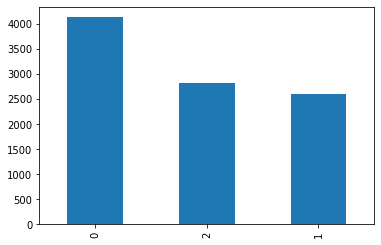

In [ ]:
train_data['labeling'].value_counts().plot(kind='bar')

In [ ]:
print(train_data.groupby('labeling').size().reset_index(name='count'))

   labeling  count
0         0   4136
1         1   2600
2         2   2819


In [ ]:
print(train_data.isnull().values.any())

False


## 한글 외 문자 제거

In [ ]:
train_data['text'] = train_data['text'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
train_data.head()

,date_time,labeling,text
2842,2021.06.17 / 22:29,1,유튜브 분석 결과 리플 가격
2867,2021.07.11 / 15:36,2,고체인 손절 오키드 손절 바운스 손절
2903,2019.01.14 / 02:04,2,이더 야
3561,2021.05.29 / 23:26,2,절대매수하지마시고 시드지키세요 개속쏘셔서 물리게만들고 손절치게만듬니다이렇게 멘탈나가...
1003,2021.02.18 / 16:37,1,비트형은 이상황에서 왜 머가리를 잡고그래


In [ ]:
train_data['text'] = train_data['text'].str.replace('^ +', '')
train_data['text'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

date_time    0
labeling     0
text         7
dtype: int64


In [ ]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

9548


In [ ]:
test_data.drop_duplicates(subset = ['text'], inplace = True)
test_data['text'] = test_data['text'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '')
test_data['text'] = test_data['text'].str.replace('^ +', '')
test_data['text'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print('전처리 후 테스트용 샘플의 개수 :', len(test_data))

전처리 후 테스트용 샘플의 개수 : 2391


## 토큰화

In [ ]:
stopwords = ['의', '가', '은', '들', '는', '좀', '잘', '걍',\
             '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [ ]:
okt = Okt()

In [ ]:
X_train = []
for sentence in tqdm(train_data['text']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence \
                                  if not word in stopwords]
    X_train.append(stopwords_removed_sentence)

print(X_train[:3])

100%|██████████| 9548/9548 [01:43<00:00, 91.88it/s] 

[['유튜브', '분석', '결과', '리플', '가격'], ['고체', '인', '손절', '오', '키드', '손절', '바운스', '손절'], ['이', '더', '야']]


In [ ]:
X_test = []
for sentence in tqdm(test_data['text']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence \
                                  if not word in stopwords]
    X_test.append(stopwords_removed_sentence)

100%|██████████| 2391/2391 [44:24<00:00,  1.11s/it]


## 정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print(tokenizer.word_index)

{'이': 1, '을': 2, '있다': 3, '더': 4, '되다': 5, '비트코인': 6, '이다': 7, '보다': 8, '비트': 9, '에서': 10, '로': 11, '코인': 12, '리플': 13, '같다': 14, '만': 15, '적': 16, '다': 17, '코박': 18, '없다': 19, '리움': 20, '고': 21, '않다': 22, '차트': 23, '것': 24, '가다': 25, '상승': 26, '까지': 27, '생각': 28, '인': 29, '하락': 30, '저': 31, '들다': 32, '아니다': 33, '좋다': 34, '점': 35, '지금': 36, '나오다': 37, '년': 38, '하고': 39, '오르다': 40, '시': 41, '때': 42, '일': 43, '오다': 44, '수': 45, '아': 46, '만원': 47, '장': 48, '나': 49, '그': 50, '시간': 51, '가격': 52, '안': 53, '월': 54, '글': 55, '지': 56, '불': 57, '정도': 58, '오늘': 59, '개': 60, '현재': 61, '사람': 62, '못': 63, '때문': 64, '요': 65, '매수': 66, '중': 67, '면': 68, '다시': 69, '원': 70, '전': 71, '말': 72, '내': 73, '알트': 74, '하': 75, '되어다': 76, '그렇다': 77, '크다': 78, '제': 79, '움직임': 80, '반등': 81, '달러': 82, '많다': 83, '투자': 84, '분': 85, '시장': 86, '한번': 87, '서': 88, '알다': 89, '게': 90, '이후': 91, '올리다': 92, '발생': 93, '계속': 94, '신호': 95, '형': 96, '드리다': 97, '이제': 98, '이번': 99, '어제': 100, '돈': 101, '분석': 102, '왜': 103, '차': 10

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 : ', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수 : %s'%(threshold -1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율 : ', (rare_cnt / total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : ', (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 :  14993
등장 빈도가 2번 이하인 희귀 단어의 수 : 8356
단어 집합에서 희귀 단어의 비율 :  55.73267524844928
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :  3.4015772604040024


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 : ', vocab_size)

단어 집합의 크기 :  6638


In [ ]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print(X_train[:3])

[[1061, 102, 571, 13, 52], [29, 260, 605, 5489, 260, 4725, 260], [1, 4, 232]]


In [ ]:
y_train = np.array(train_data['labeling'])
y_test = np.array(test_data['labeling'])

In [ ]:
# 긍정,중립,부정 3분류 3_class
word_index = tokenizer.word_index

import json
json = json.dumps(word_index)
f3 = open('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/korIndex_3_class.json', 'w')
f3.write(json)
f3.close()

In [ ]:
# # 긍정,중립,부정,배제 4분류 4_class
# word_index = tokenizer.word_index

# import json
# json = json.dumps(word_index)
# f3 = open('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/korIndex_4_class.json', 'w')
# f3.write(json)
# f3.close()

## 빈 샘플 (empty samples) 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) \
              if len(sentence) < 1]

In [ ]:
X_train = np.delete(X_train, drop_train, axis = 0)
y_train = np.delete(y_train, drop_train, axis = 0)
print(len(X_train))
print(len(y_train))

9528
9528


## 패딩

리뷰의 최대 길이 :  2623
리뷰의 평균 길이 :  31.187867338371117


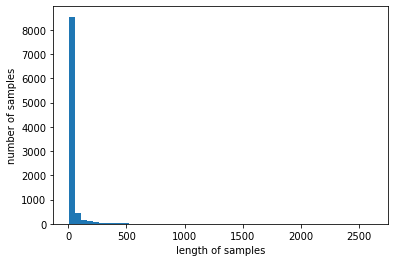

In [ ]:
print('리뷰의 최대 길이 : ', max(len(l) for l in X_train))
print('리뷰의 평균 길이 : ', sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'\
          %(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 100
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 100 이하인 샘플의 비율 : 94.08060453400505


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
## 4진분류
# np.save('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/X_train.npy', X_train)
# np.save('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/X_test.npy', X_test)
# np.save('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/y_train.npy', y_train)
# np.save('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/y_test.npy', y_test)

In [ ]:
# 3진분류
np.save('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/X_train_3_class.npy', X_train)
np.save('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/X_test_3_class.npy', X_test)
np.save('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/y_train_3_class.npy', y_train)
np.save('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/y_test_3_class.npy', y_test)

## ndarray 불러오기

In [ ]:
# # 4진분류
# X_train = np.load('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/X_train.npy')
# X_test = np.load('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/X_test.npy')
# y_train = np.load('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/y_train.npy')
# y_test = np.load('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/y_test.npy')

In [5]:
# 3진분류
X_train = np.load('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/X_train_3_class.npy')
X_test = np.load('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/X_test_3_class.npy')
y_train = np.load('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/y_train_3_class.npy')
y_test = np.load('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/y_test_3_class.npy')

In [6]:
y_train

array([1, 2, 2, ..., 1, 0, 0])

In [7]:
print(np.concatenate((y_train, y_test), axis=0))

[1 2 2 ... 0 0 2]


In [8]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

## LSTM 감성 분류

In [9]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [10]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [13]:
# vocab_size = 8430
vocab_size = 6638

embedding_dim = [12, 25, 50, 100]
hidden_units = [8, 16, 32, 64]
epochs = [400]
batch_size = [16, 32, 64, 128]
validation_split = [0.1]

recoding = []

for i in embedding_dim :
  for j in hidden_units :
    model = Sequential()
    model.add(Embedding(vocab_size, i))
    model.add(LSTM(j))
    model.add(Dense(3, activation='softmax'))

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
    # mc = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/K_4_class_best_model_1210.h5',
    mc = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/K_3_class_best_model_1210.h5',
                     monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    
    for a in epochs:
      for b in batch_size:
        for c in validation_split:
          model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
          history = model.fit(X_train, y_train, epochs=a, callbacks=[es, mc],
                                          batch_size=b, validation_split=c)
          
          # loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/K_4_class_best_model_1210.h5')
          loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/K_3_class_best_model_1210.h5')
          
          print('\n테스트 정확도 : %.4f' % (loaded_model.evaluate(X_test, y_test)[1]))
          print('embedding_dim : ', i, 'hidden_units : ', j, 'epoch : ', a, 'batch_size : ', b, 'validation_split : ', c,'\n\n')
          y = '%.4f' % (loaded_model.evaluate(X_test, y_test)[1])

          x_embedding_dim = i
          x_hidden_units = j
          x_epochs = a
          x_batch_size = b
          x_validation_split = c

          

          X = [x_embedding_dim, x_hidden_units ,x_epochs , x_batch_size, x_validation_split,y]
          recoding.append(X) 

dfr = pd.DataFrame(recoding)
dfr.columns = ['embedding_dim', 'hidden_units', 'epochs', 'batch_size',
               'validation_split', 'accuracy']
dfr.to_csv('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/best_model_lower.csv', index =False)

Epoch 1/400
535/536 [============================>.] - ETA: 0s - loss: 1.0534 - acc: 0.4440
Epoch 00001: val_acc improved from -inf to 0.47534, saving model to /content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/K_3_class_best_model_1210.h5
536/536 [==============================] - 13s 20ms/step - loss: 1.0535 - acc: 0.4441 - val_loss: 1.0218 - val_acc: 0.4753
Epoch 2/400
536/536 [==============================] - ETA: 0s - loss: 0.9770 - acc: 0.5102
Epoch 00002: val_acc improved from 0.47534 to 0.51522, saving model to /content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/K_3_class_best_model_1210.h5
536/536 [==============================] - 10s 20ms/step - loss: 0.9770 - acc: 0.5102 - val_loss: 0.9840 - val_acc: 0.5152
Epoch 3/400
534/536 [============================>.] - ETA: 0s - loss: 0.9074 - acc: 0.5833
Epoch 00003: val_acc improved from 0.51522 to 0.54250, saving model to /content/drive/MyD

In [ ]:
dfr = pd.DataFrame(recoding)
dfr.columns = ['embedding_dim', 'hidden_units', 'epochs', 'batch_size',
               'validation_split', 'accuracy']
dfr.to_csv('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/crypto_labeling_Korean/best_model_1130.csv', index =False)

NameError: ignored

In [ ]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(3, activation = 'softmax'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/3rd project/history/best_model_scc.h5',
                     monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc],
                    batch_size=64, validation_split=0.2)

Epoch 1/15
120/120 [==============================] - 6s 35ms/step - loss: 1.0255 - acc: 0.4787 - val_loss: 1.3536 - val_acc: 0.5068

Epoch 00001: val_acc improved from -inf to 0.50682, saving model to /content/drive/MyDrive/Colab Notebooks/3rd project/history/best_model_scc.h5
Epoch 2/15
120/120 [==============================] - 4s 30ms/step - loss: 0.8779 - acc: 0.6141 - val_loss: 0.9643 - val_acc: 0.5393

Epoch 00002: val_acc improved from 0.50682 to 0.53935, saving model to /content/drive/MyDrive/Colab Notebooks/3rd project/history/best_model_scc.h5
Epoch 3/15
120/120 [==============================] - 3s 28ms/step - loss: 0.7765 - acc: 0.6615 - val_loss: 0.9796 - val_acc: 0.5451

Epoch 00003: val_acc improved from 0.53935 to 0.54512, saving model to /content/drive/MyDrive/Colab Notebooks/3rd project/history/best_model_scc.h5
Epoch 4/15
120/120 [==============================] - 3s 28ms/step - loss: 0.7056 - acc: 0.7038 - val_loss: 1.0353 - val_acc: 0.5346

Epoch 00004: val_acc di

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/3rd project/history/best_model_scc.h5')
print('\n 테스트 정확도 : %.4f' % (loaded_model.evaluate(X_test, y_test)[1]))

75/75 [==============================] - 3s 34ms/step - loss: 1.1295 - acc: 0.5391

 테스트 정확도 : 0.5391


## 리뷰 예측

In [ ]:
def sentiment_predict(input, stopwords, vocab_size, word_index, loaded_model):
    input = input.replace(np.nan, "")
    input['text'] = input['title'] + ' ' + input['body']
    input.drop(['title', 'body'], axis=1, inplace=True)
    input['text'] = input['text'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')

    new_sentence = []
    for sentence in tqdm(input['text']):
        tokenized_sentence = okt.morphs(sentence, stem=True)
        stopwords_removed_sentence = [word for word in tokenized_sentence \
                                      if not word in stopwords]
        new_sentence.append(stopwords_removed_sentence)

    tokenizer = Tokenizer(vocab_size)
    tokenizer.word_index = word_index
    encoded = tokenizer.texts_to_sequences(new_sentence)
    pad_new = pad_sequences(encoded, maxlen = max_len)
    # input['sentiment'] = loaded_model.predict(pad_new)

    # input['s'] = 1
    # input.loc[input['sentiment'] < 0.67, 's'] = 0
    # input.loc[input['sentiment'] >= 1.34, 's'] = 2

In [ ]:
input = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/3rd project/data/kor/alt_x.csv', sep=',', encoding='cp949')

import json
with open('/content/drive/MyDrive/Colab Notebooks/3rd project/korIndex.json') as json_file:
    word_index = json.load(json_file)

from keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/3rd project/history/best_model_mse.h5')

In [ ]:
sentiment_predict(input, stopwords, vocab_size, word_index, loaded_model)

100%|██████████| 4198/4198 [00:53<00:00, 78.32it/s] 


In [ ]:
input.head()

,title,body,date_time
0,공식 어플 설치하고 코인정보를 받아보세요!,"5월 31일, 코인판 공식 어플이 드디어 출시되었습니다.\n이제, 코인판?어플을 통...",2016.05.31 / 21:19
1,코박토큰 어제 12시에 존나 날라가더만,NaN,2021.10.30 / 17:17
2,시총 144 억 코박이 하고 놀자,NaN,2021.10.30 / 15:27
3,쿼크가면 코박간다,NaN,2021.10.30 / 13:05
4,불나방 안했으면 좋겠다.,NaN,2021.10.30 / 12:54


In [14]:
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   embedding_dim     64 non-null     int64  
 1   hidden_units      64 non-null     int64  
 2   epochs            64 non-null     int64  
 3   batch_size        64 non-null     int64  
 4   validation_split  64 non-null     float64
 5   accuracy          64 non-null     object 
dtypes: float64(1), int64(4), object(1)
memory usage: 3.1+ KB


In [15]:
dfr['accuracy'].max()

'0.5680'

KeyError: ignored

In [21]:
iloc.

SyntaxError: ignored